# **Using Natural Language Processing (NLP) to extract category names with product descriptions**
### *This notebook implements a pipeline to classify category names from clothing product descriptions, generate platform-specific listings for eBay and Vinted, and evaluate the quality of the generated text. The pipeline leverages a fine-tuned BERT model for category classification and a large language model (LLM) for generating titles and descriptions. ROUGE and BLEU evaluation metrics are then used to assess performance of the generated text. The goal is to automate the creation of accurate, platform-specific clothing listings using two datasets, with a focus on keyword precision and relevance.*

## **Setting-up**
#### We will start by installing and importing the required packages and libraries for natural language processing, machine learning, and evaluation.


In [ ]:
!pip install ollama torch transformers joblib colab-xterm rouge-score nltk matplotlib numpy seaborn
%load_ext colabxterm

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 10.1 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size

In [ ]:
# Import libraries
import re
import nltk
import json
import torch
import ollama
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from html import escape
from typing import List, Dict
import matplotlib.pyplot as plt
from transformers import BertModel
from rouge_score import rouge_scorer
from transformers import BertTokenizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## **Loading the BERT model**
#### We load a pre-trained BERT model fine-tuned for multi-task multi-class classification to predict eBay and Vinted category labels. Make sure to download the ZIP file `bert_category_classifier_complete.zip` from the previoous notebook results and place the folder in the correct directory to execute the cells succesfully.

In [ ]:
!unzip bert_category_classifier_complete.zip

Archive:  bert_category_classifier_complete.zip
   creating: bert_category_classifier/
  inflating: best_bert_category_classifier.pth  
  inflating: model_config.json       
  inflating: bert_category_classifier_full.pth  
  inflating: vinted_encoder.pkl      
  inflating: ebay_encoder.pkl        
  inflating: bert_category_classifier/tokenizer_config.json  
  inflating: bert_category_classifier/config.json  
  inflating: bert_category_classifier/model.safetensors  
  inflating: bert_category_classifier/special_tokens_map.json  
  inflating: bert_category_classifier/vocab.txt  


#### The **`BertForMultiTaskClassification`** class defines a custom BERT model for simultaneous classification of eBay and Vinted categories. It extends the pretrained uncased BERT model with two linear classifiers for platform-specific category prediction and a dropout layer to mitigate risks of overfitting.

In [ ]:
class BertForMultiTaskClassification(nn.Module):
    def __init__(self, num_vinted_classes, num_ebay_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.vinted_classifier = nn.Linear(768, num_vinted_classes)
        self.ebay_classifier = nn.Linear(768, num_ebay_classes)

    def forward(self, input_ids, attention_mask, vinted_labels=None, ebay_labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        vinted_logits = self.vinted_classifier(pooled_output)
        ebay_logits = self.ebay_classifier(pooled_output)
        loss = None
        if vinted_labels is not None and ebay_labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            vinted_loss = loss_fn(vinted_logits, vinted_labels)
            ebay_loss = loss_fn(ebay_logits, ebay_labels)
            loss = vinted_loss + ebay_loss
        return {'loss': loss, 'vinted_logits': vinted_logits, 'ebay_logits': ebay_logits}

#### The model configuration, tokenizer, and label encoders are loaded from the save files to ensure consistency and reproducibility.

In [ ]:
# Load model configuration
with open('model_config.json', 'r') as f:
    config = json.load(f)
num_vinted_classes = config['num_vinted_classes']
num_ebay_classes = config['num_ebay_classes']

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model = BertForMultiTaskClassification(num_vinted_classes, num_ebay_classes)
bert_model.load_state_dict(torch.load('best_bert_category_classifier.pth', map_location=device))
bert_model.to(device)
bert_model.eval()

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('/content/bert_category_classifier')

# Load encoders
vinted_encoder = joblib.load('vinted_encoder.pkl')
ebay_encoder = joblib.load('ebay_encoder.pkl')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## **Setting-up Ollama Models for Inference**
#### We define three utility functions to support title/description generation:
#### **`create_chat_messages`**: Constructs a list of chat messages with few-shot examples to prompt an LLM into generating platform-specific text.
#### **`generate_text`**: Uses the LLM to generate titles and descriptions based on the provided item attributes into an easily parsable format.
#### **`_parse_listing_text`**: Parses the LLM-generated text into a structured dictionary containing platform-specific titles and descriptions for easy of use in the rest of the pipeline.



In [ ]:
def create_chat_messages(attributes: Dict) -> List[Dict[str, str]]:
    examples = [
        {
            "attributes": {
                "product": "Basic T-Shirt Cotton Short Sleeve",
                "gender": "Women",
                "color": "Blue",
                "category": {
                    "vinted": "Women > Clothing > Tops & t-shirts > T-shirts",
                    "ebay": "Clothing, Shoes & Accessories > Women > Women's Clothing > Tops"
                },
                "size": "M",
                "condition": "2"
            },
            "vinted": {
                "title": "Blauw Bershka T-shirt",
                "description": "Mooi blauw T-shirt, maat M, amper gedragen, goede staat."
            },
            "ebay": {
                "title": "Women's Blue Cotton T-Shirt Short Sleeve Size M Good Condition",
                "description": "Premium women's blue cotton T-shirt, size M, in good condition. Slim fit, stretchy fabric, scoop neck, short sleeves. Perfect for casual wear or layering. Machine washable, no stains or tears. True to size, ideal for everyday comfort."
            }
        },
        {
            "attributes": {
                "product": "Sundress Summer Sleeveless",
                "gender": "Women",
                "color": "Red",
                "category": {
                    "vinted": "Women > Clothing > Dresses > Midi dresses",
                    "ebay": "Clothing, Shoes & Accessories > Women > Women's Clothing > Dresses"
                },
                "size": "S",
                "condition": "3"
            },
            "vinted": {
                "title": "Rode Zomerjurk",
                "description": "Prachtige rode jurk, maat S, zo goed als nieuw, perfect voor de zomer."
            },
            "ebay": {
                "title": "Women's Red Sleeveless Sundress Size S Like New",
                "description": "Stunning red sleeveless sundress, size S, in excellent condition. Lightweight, breathable fabric, ideal for summer outings or parties. Midi length, flattering fit. No damage or wear, machine washable. Perfect for vacations or special occasions."
            }
        },
        {
            "attributes": {
                "product": "H&M Denim Jeans",
                "gender": "Men",
                "color": "Blue",
                "category": {
                    "vinted": "Men > Clothing > Jeans > Slim jeans",
                    "ebay": "Clothing, Shoes & Accessories > Men > Men's Clothing > Jeans"
                },
                "size": "L",
                "condition": "3"
            },
            "vinted": {
                "title": "H&M Slim Jeans Blauw",
                "description": "Blauwe H&M jeans, maat L, zo goed als nieuw, comfortabele pasvorm."
            },
            "ebay": {
                "title": "Men's H&M Blue Denim Slim Fit Jeans Size L Like New",
                "description": "High-quality H&M men's blue denim jeans, size L, in excellent condition. Slim fit, durable fabric, perfect for casual or semi-formal settings. Five-pocket style, machine washable, no signs of wear. Ideal for everyday wear or dressing up."
            }
        },
        {
            "attributes": {
                "product": "Zara Wool Coat",
                "gender": "Women",
                "color": "Black",
                "category": {
                    "vinted": "Women > Clothing > Outerwear > Coats > Long coats",
                    "ebay": "Clothing, Shoes & Accessories > Women > Women's Clothing > Coats, Jackets & Vests"
                },
                "size": "XS",
                "condition": "1"
            },
            "vinted": {
                "title": "Zwart Zara Wollen Jas",
                "description": "Zwarte wollen jas, maat XS, in redelijke staat, warm en stijlvol."
            },
            "ebay": {
                "title": "Women's Zara Black Wool Coat Size XS Fair Condition",
                "description": "Elegant Zara women's black wool coat, size XS, in fair condition. Warm, stylish design with button closure, perfect for winter. Minor signs of wear, fully functional. Dry clean recommended. Ideal for professional or casual outfits."
            }
        },
        {
            "attributes": {
                "product": "Nike Running Shoes",
                "gender": "Men",
                "color": "Grey",
                "category": {
                    "vinted": "Men > Shoes > Sneakers > Running sneakers",
                    "ebay": "Clothing, Shoes & Accessories > Men > Men's Shoes > Athletic Shoes"
                },
                "size": "XL",
                "condition": "2"
            },
            "vinted": {
                "title": "Grijze Nike Schoenen",
                "description": "Nike hardloopschoenen, maat XL, goede staat, ideaal voor sporten."
            },
            "ebay": {
                "title": "Men's Nike Grey Running Shoes Size XL Good Condition",
                "description": "Men's Nike grey running shoes, size XL, in good condition. Lightweight, breathable mesh upper, cushioned sole for comfort. Perfect for running, gym, or casual wear. Minor wear on soles, cleaned and ready to use. True to size."
            }
        }
    ]

    messages = []

    # System Role Message
    system_content = """You are an expert at generating clothing and accessory listings for second-hand marketplaces Vinted and eBay.
    Given attributes (product (short item description), gender (Men or Women), color, Vinted category, eBay category, size (XS, S, M, L, XL), condition (1-3 stars, where 3=excellent, 2=good, 1=fair)), create concise, platform-specific listings.

    For Vinted:
    - Titles: In Dutch, trendy and catchy.
    - Descriptions: In Dutch, casual and engaging. Include product, color, size, and condition.

    For eBay:
    - Titles: In English, keyword-rich for searchability.
    - Descriptions: In English, detailed with fit, material, care instructions, and usage scenarios. Include product, color, size, and condition.

    Always try to include all provided attributes in the output. If some attributes are missing or inaccurate, don't mention it in your output. Generate only the titles and descriptions, using this strict format below (NO EXCEPTIONS):
    === Vinted ===
    Title: <vinted_title>
    Description: <vinted_description> =====

    === eBay ===
    Title: <ebay_title>
    Description: <ebay_description> =====
    """
    messages.append({"role": "system", "content": system_content})

    # Example Conversations
    for example in examples:
        ex_attributes = example["attributes"]
        user_example_content = f"""Please generate listings for the following attributes:
        Product: {ex_attributes['product']}
        Gender: {ex_attributes['gender']}
        Color: {ex_attributes['color']}
        Vinted Category: {ex_attributes['category']['vinted']}
        eBay Category: {ex_attributes['category']['ebay']}
        Size: {ex_attributes['size']}
        Condition: {ex_attributes['condition']}
        """
        messages.append({"role": "user", "content": user_example_content})

        assistant_example_content = f"""=== Vinted ===
        Title: {example['vinted']['title']}
        Description: {example['vinted']['description']} =====

        === eBay ===
        Title: {example['ebay']['title']}
        Description: {example['ebay']['description']} =====
        """
        messages.append({"role": "assistant", "content": assistant_example_content})

    # Final User Request
    final_user_content = f"""Now, please generate listings for the following item:
        Product: {attributes['product']}
        Gender: {attributes['gender']}
        Color: {attributes['color']}
        Vinted Category: {attributes['category']['vinted']}
        eBay Category: {attributes['category']['ebay']}
        Size: {attributes['size']}
        Condition: {attributes['condition']}
        """
    messages.append({"role": "user", "content": final_user_content})

    return messages

def generate_text(attributes: Dict, model: str) -> str:
    chat_messages = create_chat_messages(attributes)
    response = ollama.chat(model=model, messages=chat_messages)
    return response['message']['content']

def _parse_listing_text(listing_text):
    try:
        platform_listings = {}
        sections = listing_text.split('=== ')[1:]
        for section in sections:
            platform, content = section.split(' ===\n', 1) # Exctract platform name and its title/description content
            title_start = content.index('Title: ') + len('Title: ')
            description_start = content.index('ion:') + len('ion:') # Tinyllama often outputs "Descripion:", instead of "Description:". We will permit only such slack.
            title_end = content.index('Descrip')
            description_end = content.index('=====')
            title = content[title_start:title_end].strip() # Exctract title with found indices and remove trailing whitespaces
            description = content[description_start:description_end].strip() # Same for description part of this platform's content
            platform_listings[platform] = {'title': escape(title), 'description': description}
    except:
        return None

    return platform_listings

#### To make use of the pretrained models provided by Ollama, we will need to connect to the ollama server with a personal access token. You can retrieve the your token by visiting `https://huggingface.co/settings/tokens`. You can then run the cell below and follow the prompt instructions to get access to the huggingface hub.

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
The token `Thesis` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `Thesis`


#### Launch the xterm CLI and copy and paste the lines directly into xterm. This ensures that the Ollama server is running and the 4 specified models are downloaded (**tinyllama** (\~638MB), **smollm2** (\~1.8GB), **mistral** (\~4.1GB), **phi4** (\~9.1GB)). The xterm CLI is used because Colab requires an interactive terminal for these setup commands. This way the Ollama server can run in the background, while allowing us to execute remaining cells.

In [ ]:
%xterm

Launching Xterm...

<IPython.core.display.Javascript object>

In [ ]:
# Copy/paste this entire cell into the xterm terminal that opened and wait
# for it to finish downloading everything (~4 min) before continuing
curl -fsSL https://ollama.ai/install.sh | sh
ollama serve &
ollama list # Placeholder line to stall time (ensures tinyllama pull doesn't get skipped)
ollama pull tinyllama
ollama pull smollm2
ollama pull mistral
ollama pull phi4
ollama list

In [ ]:
# NAME                ID              SIZE      MODIFIED
# phi4:latest         ac896e5b8b34    9.1 GB    Less than a second ago
# mistral:latest      3944fe81ec14    4.1 GB    3 minutes ago
# smollm2:latest      cef4a1e09247    1.8 GB    4 minutes ago
# tinyllama:latest    2644915ede35    637 MB    4 minutes ago

## **Data loading, Preprocessing & Evaluation**
#### Make sure to download the `llm_data.zip` file from github.
#### **`load_dataset`**: This function loads the dataset from the CSV file containing product data. We filter the dataset so that only 'Men' and 'Women' gender categories remain.
#### **`evaluate_listings`**: It runs a specified subset of the dataset through the pipeline to evaluate the generated eBay descriptions against ground-truth descriptions using ROUGE and BLEU metrics.

In [ ]:
!unzip llm_data.zip

Archive:  llm_data.zip
  inflating: custom_products_catalog.csv  
  inflating: myntra_products_catalog.csv  


In [ ]:
def load_dataset(csv_file):
    data = pd.read_csv(csv_file, on_bad_lines='skip')
    data = data[data['Gender'].isin(['Men', 'Women'])]  # Filter Unisex
    return data

def evaluate_listings(data, marketplace, num_samples, bert_model, tokenizer, vinted_encoder, ebay_encoder, llm_model, verbose=False):
    results = [] # Store metrics
    output = [] # Store all llm generated text
    fail_count = 0 # Keep track of failure to comply to strict prompt output format
    if verbose:
        print(f"Generating with {model.upper()}")
    for index, row in data.head(num_samples).iterrows():
        if verbose:
            print('.', end='')
        product_name = row['ProductName']
        primary_color = row['PrimaryColor']
        gender = row['Gender']
        if marketplace == "eBay":
            price = round(row['Price (INR)'] / 99.24, 2) # To EUR
        else:
            price = row['Price (EUR)']
        description = row['Description']
        size = '' # Placeholders since attributes are not in data
        condition = ''

        # Predict categories using BERT
        input_text = f"{gender}'s {product_name}"
        inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True).to(device)
        del inputs['token_type_ids']
        with torch.no_grad():
            outputs = bert_model(**inputs)
        vinted_category = vinted_encoder.inverse_transform([torch.argmax(outputs['vinted_logits'], dim=1).cpu().numpy()[0]])[0]
        ebay_category = ebay_encoder.inverse_transform([torch.argmax(outputs['ebay_logits'], dim=1).cpu().numpy()[0]])[0]

        # Create attributes dictionary
        attributes = {
            'product': product_name,
            'gender': gender,
            'color': primary_color,
            'category': {
                'vinted': vinted_category,
                'ebay': ebay_category
            },
            'size': size,
            'condition': condition,
            'price': price
        }

        # Generate listings
        listing_text = generate_text(attributes, llm_model)
        platform_listings = _parse_listing_text(listing_text)

        try:
            generated_ebay_description = platform_listings['eBay']['description']
            generated_vinted_description = platform_listings['Vinted']['description']
            output.append({
            'model': llm_model,
            'llm_output': listing_text,
            'ebay_description': generated_ebay_description,
            'vinted_description': generated_vinted_description
            })
        except:
            fail_count += 1
            output.append({
            'model': llm_model,
            'llm_output': listing_text,
            'ebay_description': "",
            'vinted_description': ""
            })

            if verbose:
                print(f"\nIncorrect parsing for data entry with index {index} for {llm_model}. Skipping this entry.\n")
            continue

        # Preprocces descriptions for evaluation
        reference = re.sub('<.*?>', '', description)  # Remove earlier created HTML tags
        reference = ' '.join(reference.split()).lower()  # Normalize whitespace and lowercase
        if marketplace == "eBay":
            candidate = re.sub('<.*?>', '', generated_ebay_description) # Same preprocessing for candidate
            candidate = ' '.join(candidate.split()).lower()
        elif marketplace == "Vinted":
            candidate = re.sub('<.*?>', '', generated_vinted_description) # Same preprocessing for candidate
            candidate = ' '.join(candidate.split()).lower()

        # Calculate ROUGE and BLEU scores
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
        rouge_scores = scorer.score(reference.lower(), candidate.lower())
        smoothing_function = SmoothingFunction().method1
        reference_tokens = nltk.word_tokenize(reference.lower())
        candidate_tokens = nltk.word_tokenize(candidate.lower())
        standard_bleu_score = sentence_bleu([reference_tokens], candidate_tokens, smoothing_function=smoothing_function)
        unigram_bleu_score = sentence_bleu([reference_tokens], candidate_tokens, smoothing_function=smoothing_function, weights=(1, 0, 0, 0))

        results.append({
            'ProductName': product_name,
            'rouge1': rouge_scores['rouge1'].fmeasure,
            'rougeL': rouge_scores['rougeL'].fmeasure,
            'bleu_standard': standard_bleu_score,
            'bleu_unigram': unigram_bleu_score
        })
    results_df = pd.DataFrame(results)
    output_df = pd.DataFrame(output)

    if verbose:
        print(results_df)

    return results_df, output_df, fail_count

#### We fill the input to our earlier defined functions to evaluate the listing generation pipeline on a specified number of samples. The ROUGE-1, ROUGE-L, and BLEU metrics are computed to assess the quality of generated eBay descriptions compared to ground-truth descriptions.

In [ ]:
# Load dataset
data = load_dataset('myntra_products_catalog.csv')

In [ ]:
# Store evaluation metrics
all_results = {}  # Store results for all models
num_samples = 100
models = ['tinyllama', 'smollm2', 'mistral', 'phi4']

# Iterate over the downloaded models
for model in models:
    results_df, model_outputdf, failed_count = evaluate_listings(data, "eBay", num_samples, bert_model, tokenizer, vinted_encoder, ebay_encoder, llm_model=model, verbose=True)
    if results_df.empty:
        print(f"\nFailure generating any listings with {model}")
        continue

    all_results[model] = {'results_df': results_df, 'output': model_outputdf, 'failed_count': failed_count}

    # Display model results
    print(f"\nEvaluation Results {model}")

    print("\nAverage Scores:")
    print(f"Average ROUGE-1: {results_df['rouge1'].mean():.4f}")
    print(f"Average ROUGE-L: {results_df['rougeL'].mean():.4f}")
    print(f"Average BLEU (Standard): {results_df['bleu_standard'].mean():.4f}")
    print(f"Average BLEU (Unigrams Only): {results_df['bleu_unigram'].mean():.4f}")
    print(f"{model.upper()} failed to parse {failed_count} out of {num_samples} total entries.")

Generating with TINYLLAMA
.
Incorrect parsing for data entry with index 1 for tinyllama. Skipping this entry.

.....
Incorrect parsing for data entry with index 6 for tinyllama. Skipping this entry.

.........
Incorrect parsing for data entry with index 18 for tinyllama. Skipping this entry.

.
Incorrect parsing for data entry with index 19 for tinyllama. Skipping this entry.

.
Incorrect parsing for data entry with index 20 for tinyllama. Skipping this entry.

...
Incorrect parsing for data entry with index 24 for tinyllama. Skipping this entry.

.
Incorrect parsing for data entry with index 25 for tinyllama. Skipping this entry.

.
Incorrect parsing for data entry with index 27 for tinyllama. Skipping this entry.

.
Incorrect parsing for data entry with index 30 for tinyllama. Skipping this entry.

.
Incorrect parsing for data entry with index 31 for tinyllama. Skipping this entry.

.
Incorrect parsing for data entry with index 32 for tinyllama. Skipping this entry.

..
Incorrect par

In [ ]:
for model in models:
    print(f"\nModel: {model}")
    try:
        # Access the llm_output list for the model
        llm_outputs = all_results[model]['output']['llm_output']
        # Process only the first 5 entries (or fewer if less than 5 exist)
        for i, listing_text in enumerate(llm_outputs[:5], 1):
            parsed_result = _parse_listing_text(listing_text)
            if parsed_result:
                print(f"\nRow {i}:")
                for platform, data in parsed_result.items():
                    print(f"  {platform}:")
                    print(f"    Title: {data['title']}")
                    print(f"    Description: {data['description']}")
            else:
                print(f"\nRow {i}: Failed to parse listing text")
    except (KeyError, TypeError) as e:
        print(f"Error accessing data for model {model}: {e}")


Model: tinyllama

Row 1:
  Vinted:
    Title: EthnoVogue Women&#x27;s Beige and Grey Make-To-Measure Cut-To-Suit Kurtis Set with Jacket
    Description: EthnoVogue women's beige and grey make-to-measure kurtis set, jacket. Made to measure cut-to-suit, perfect for casual wear or semi-formal occasions. Beige kurta has two-button closure, cuffed sleeves, and loose fit. Grey kurta is one size fits most, and features a button closure, low back, and loose fit. Jacket comes with long sleeves, zipper closure at the back, and a single button closure on the left side. Sizing: 
        XS (US) or Size to be determined (UK), based on customer's measurements. Shipping: Free shipping worldwide.

Row 2:
  Vinted:
    Title: SPYKAR Womens Pink Alexa Super Skippn High-Rise Crop Jeans
    Description: SPYKAR Women's Pink Alexa Super Skippn High-Rise Crop Jeans, size 32/W89, in perfect condition. The jeans are clean and come with the original tags attached. The fit is high-rise and cropped. A must-have 

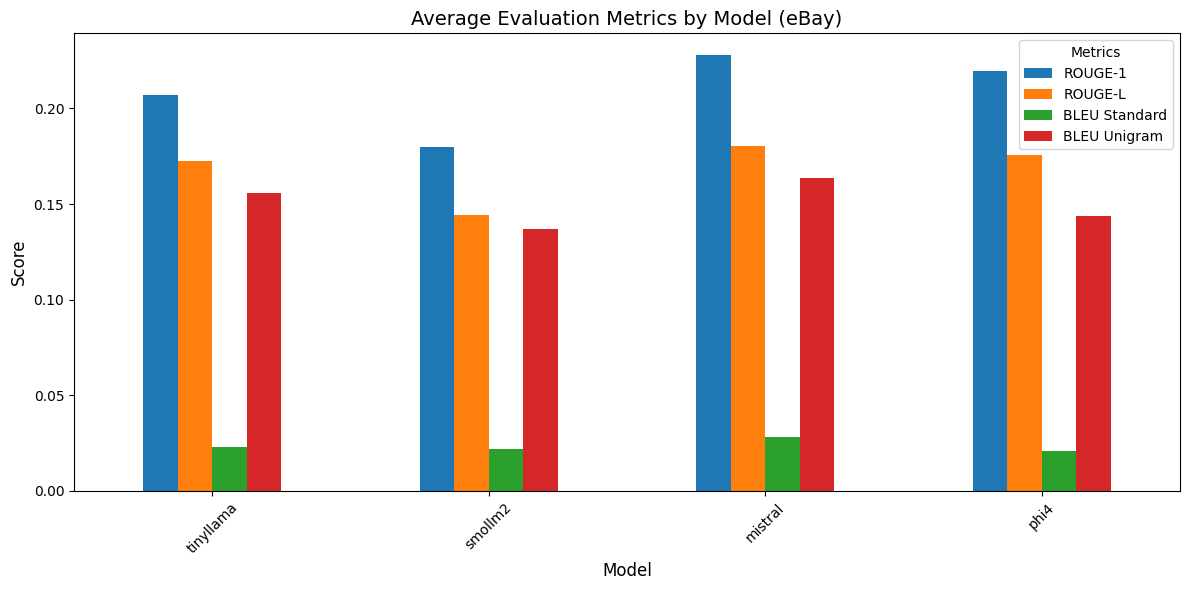

In [ ]:
# Prepare data for bar plot
metrics = ['rouge1', 'rougeL', 'bleu_standard', 'bleu_unigram']
avg_scores = {model: all_results[model]['results_df'][metrics].mean() for model in all_results}

# Convert to DataFrame for plotting
avg_scores_df = pd.DataFrame(avg_scores).T
avg_scores_df.columns = ['ROUGE-1', 'ROUGE-L', 'BLEU Standard', 'BLEU Unigram']

# Plot grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))
avg_scores_df.plot(kind='bar', ax=ax)
ax.set_title('Average Evaluation Metrics by Model (eBay)', fontsize=14)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.legend(title='Metrics', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("eBay Bar Plots LLM Results.png")
plt.show()

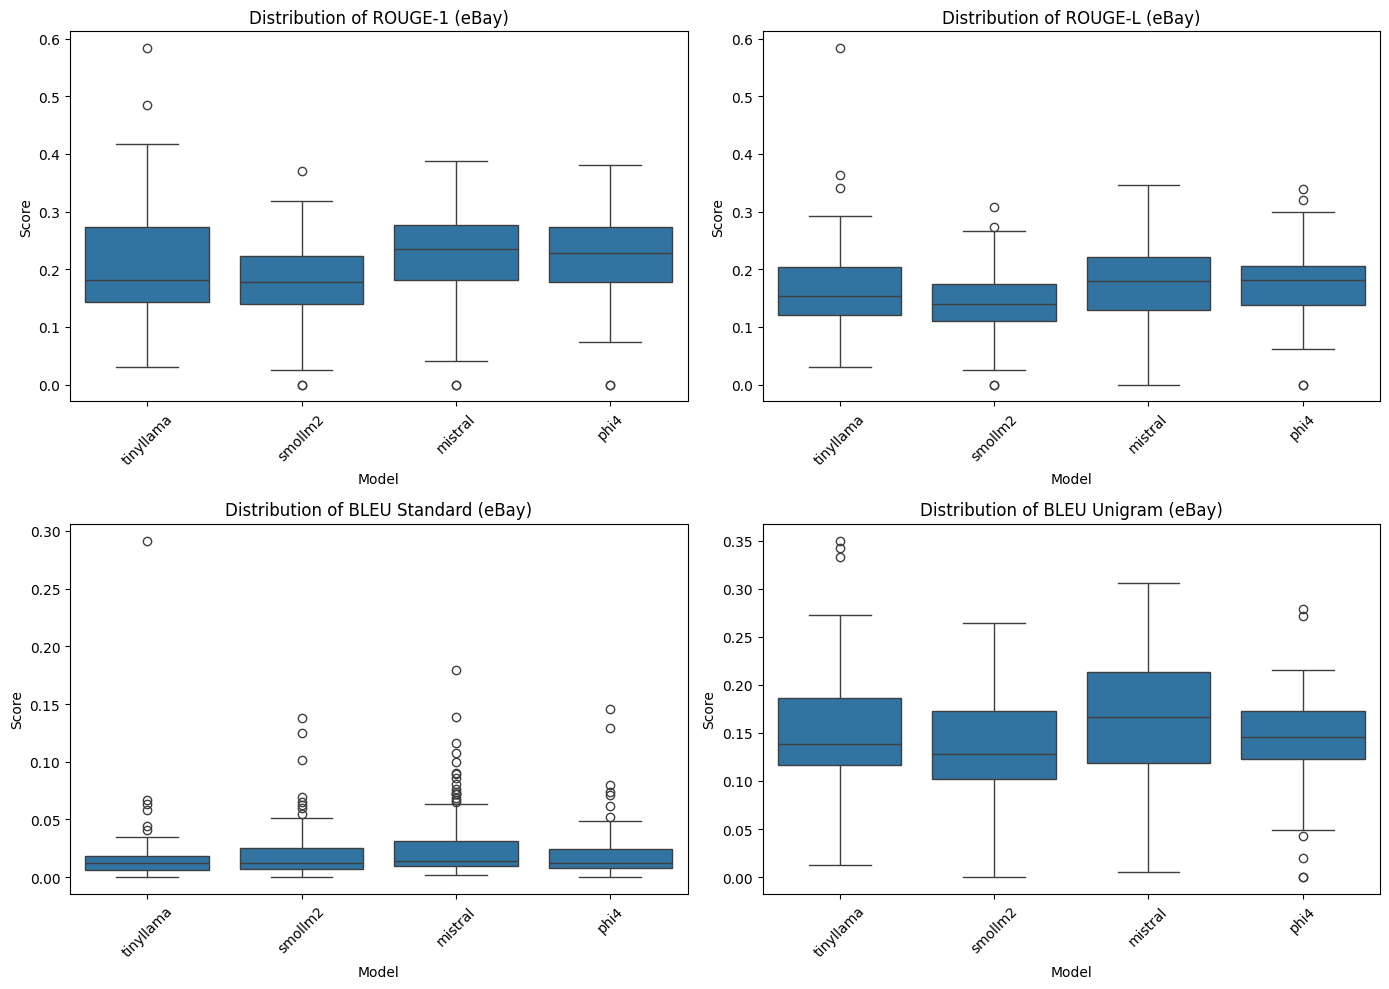

In [ ]:
# Box plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
metric_labels = ['ROUGE-1', 'ROUGE-L', 'BLEU Standard', 'BLEU Unigram']

for i, metric in enumerate(metrics):
    # Combine data for each metric across models
    data = pd.concat([all_results[model]['results_df'][[metric]].assign(Model=model)
                      for model in all_results], axis=0)
    sns.boxplot(x='Model', y=metric, data=data, ax=axes[i])
    axes[i].set_title(f'Distribution of {metric_labels[i]} (eBay)', fontsize=12)
    axes[i].set_xlabel('Model', fontsize=10)
    axes[i].set_ylabel('Score', fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("eBay Box Plots LLM Results.png")
plt.show()

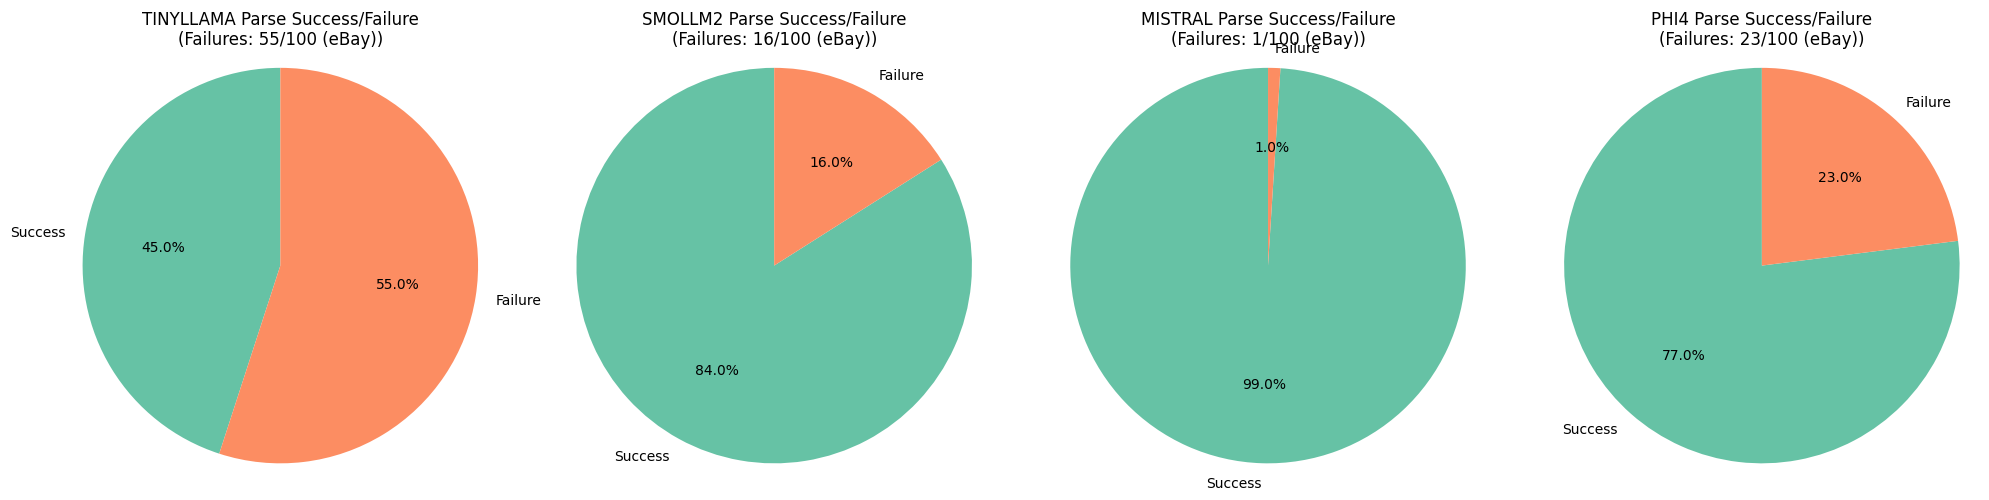

In [ ]:
# Pie charts for each model
fig, axes = plt.subplots(1, len(all_results), figsize=(5 * len(all_results), 5))
if len(all_results) == 1:
    axes = [axes]  # Handle single model case

for i, model in enumerate(all_results):
    failed = all_results[model]['failed_count']
    success = num_samples - failed
    labels = ['Success', 'Failure']
    sizes = [success, failed]
    colors = ['#66c2a5', '#fc8d62']  # Green and orange for success and failure
    axes[i].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'{model.upper()} Parse Success/Failure\n(Failures: {failed}/{num_samples} (eBay))', fontsize=12)
    axes[i].axis('equal')  # Equal aspect ratio for circular pie

plt.tight_layout()
plt.savefig("Parsing Success Rates.png")
plt.show()

#### We will then do the same but on the Vinted descriptions, to be able compare our pipeline's English vs. Dutch text generation performance.

In [ ]:
# Load dataset
data = pd.read_csv('custom_products_catalog.csv')

In [ ]:
# Store evaluation metrics
all_results = {}  # Store results for all models
num_samples = 100
models = ['tinyllama', 'smollm2', 'mistral', 'phi4']

# Iterate over the downloaded models
for model in models:
    results_df, model_outputdf, failed_count = evaluate_listings(data, "Vinted", num_samples, bert_model, tokenizer, vinted_encoder, ebay_encoder, llm_model=model, verbose=True)
    if results_df.empty:
        print(f"Failure generating any listings with {model}")
        continue

    all_results[model] = {'results_df': results_df, 'output': model_outputdf, 'failed_count': failed_count}

    # Display model results
    print(f"\nEvaluation Results {model}")

    print("\nAverage Scores:")
    print(f"Average ROUGE-1: {results_df['rouge1'].mean():.4f}")
    print(f"Average ROUGE-L: {results_df['rougeL'].mean():.4f}")
    print(f"Average BLEU (Standard): {results_df['bleu_standard'].mean():.4f}")
    print(f"Average BLEU (Unigrams Only): {results_df['bleu_unigram'].mean():.4f}")
    print(f"{model.upper()} failed to parse {failed_count} out of {num_samples} total entries.")

Generating with TINYLLAMA
....
Incorrect parsing for data entry with index 3 for tinyllama. Skipping this entry.

..............
Incorrect parsing for data entry with index 17 for tinyllama. Skipping this entry.

...
Incorrect parsing for data entry with index 20 for tinyllama. Skipping this entry.

.
Incorrect parsing for data entry with index 21 for tinyllama. Skipping this entry.

....
Incorrect parsing for data entry with index 25 for tinyllama. Skipping this entry.

.
Incorrect parsing for data entry with index 26 for tinyllama. Skipping this entry.

....
Incorrect parsing for data entry with index 30 for tinyllama. Skipping this entry.

..
Incorrect parsing for data entry with index 32 for tinyllama. Skipping this entry.

........
Incorrect parsing for data entry with index 40 for tinyllama. Skipping this entry.

.
Incorrect parsing for data entry with index 41 for tinyllama. Skipping this entry.

......
Incorrect parsing for data entry with index 47 for tinyllama. Skipping this 

In [ ]:
for model in models:
    print(f"\nModel: {model}")
    try:
        # Access the llm_output list for the model
        llm_outputs = all_results[model]['output']['llm_output']
        # Process only the first 5 entries (or fewer if less than 5 exist)
        for i, listing_text in enumerate(llm_outputs[:5], 1):
            parsed_result = _parse_listing_text(listing_text)
            if parsed_result:
                print(f"\nRow {i}:")
                for platform, data in parsed_result.items():
                    print(f"  {platform}:")
                    print(f"    Title: {data['title']}")
                    print(f"    Description: {data['description']}")
            else:
                print(f"\nRow {i}: Failed to parse listing text")
    except (KeyError, TypeError) as e:
        print(f"Error accessing data for model {model}: {e}")


Model: tinyllama

Row 1:
  Vinted:
    Title: Bordeuwe Cloche Zonder Zilver
    Description: Flared corduroy broek, bordeaux rood, maat 6/7, goed voor de zomer.
  eBay:
    Title: Women&#x27;s Bordeuwe Red Cape Size 6/7 Good for Summer
    Description: Women's flared corduroy broek with bordeuwrood color, size 6/7. Ideal for the summer season. Perfect for all occasions or casual wear. Minor signs of wear, cleaned and ready to use. True to size, ideal for a large number of sizes. Item will be shipped within 24 hours after payment is received.

Row 2:
  Vinted:
    Title: Denim Jack Oversized Blauw Donkerblauwe
    Description: Denim jack, oversized blauw donkerblauwe, maat S, goed om te zorgen voor je dag.
  eBay:
    Title: Men&#x27;s Oversized Denim Jack Oversize Blaue Jeans 16&quot; Sleeve Size S - 3XL (Donkerblauws)
    Description: Donkerblauwe oversize denim jack, Sleeves of size 16", size S to XL. Ideal for casual and semi-formal settings. Perfect for everyday wear or dressing u

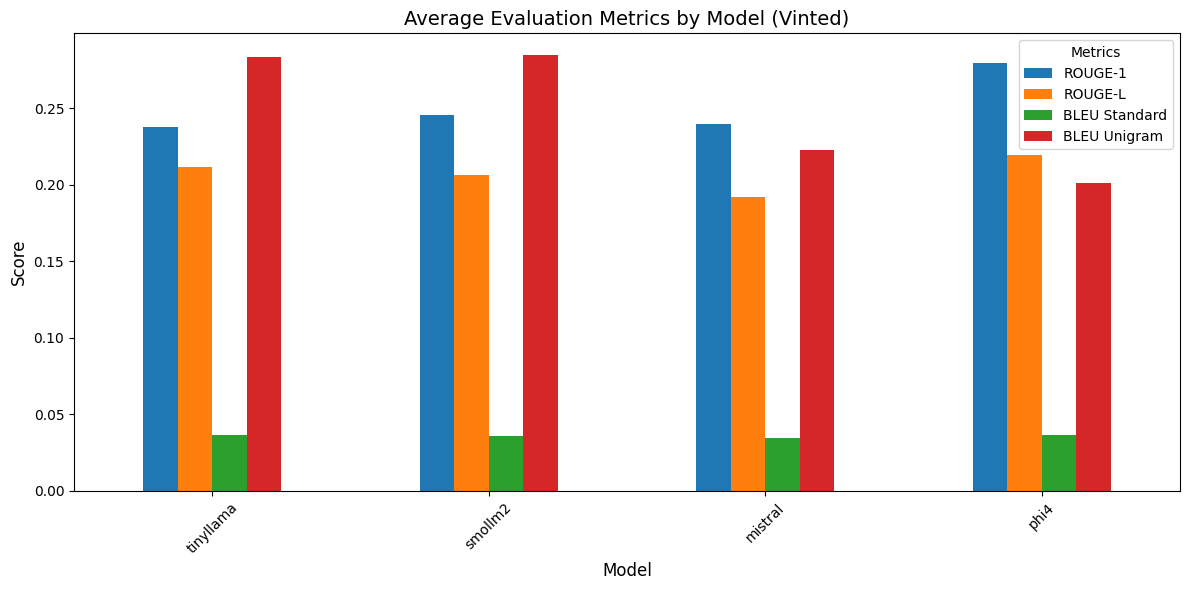

In [ ]:
# Prepare data for bar plot
metrics = ['rouge1', 'rougeL', 'bleu_standard', 'bleu_unigram']
avg_scores = {model: all_results[model]['results_df'][metrics].mean() for model in all_results}

# Convert to DataFrame for plotting
avg_scores_df = pd.DataFrame(avg_scores).T
avg_scores_df.columns = ['ROUGE-1', 'ROUGE-L', 'BLEU Standard', 'BLEU Unigram']

# Plot grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))
avg_scores_df.plot(kind='bar', ax=ax)
ax.set_title('Average Evaluation Metrics by Model (Vinted)', fontsize=14)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.legend(title='Metrics', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Vinted Bar Plots LLM Results.png")
plt.show()

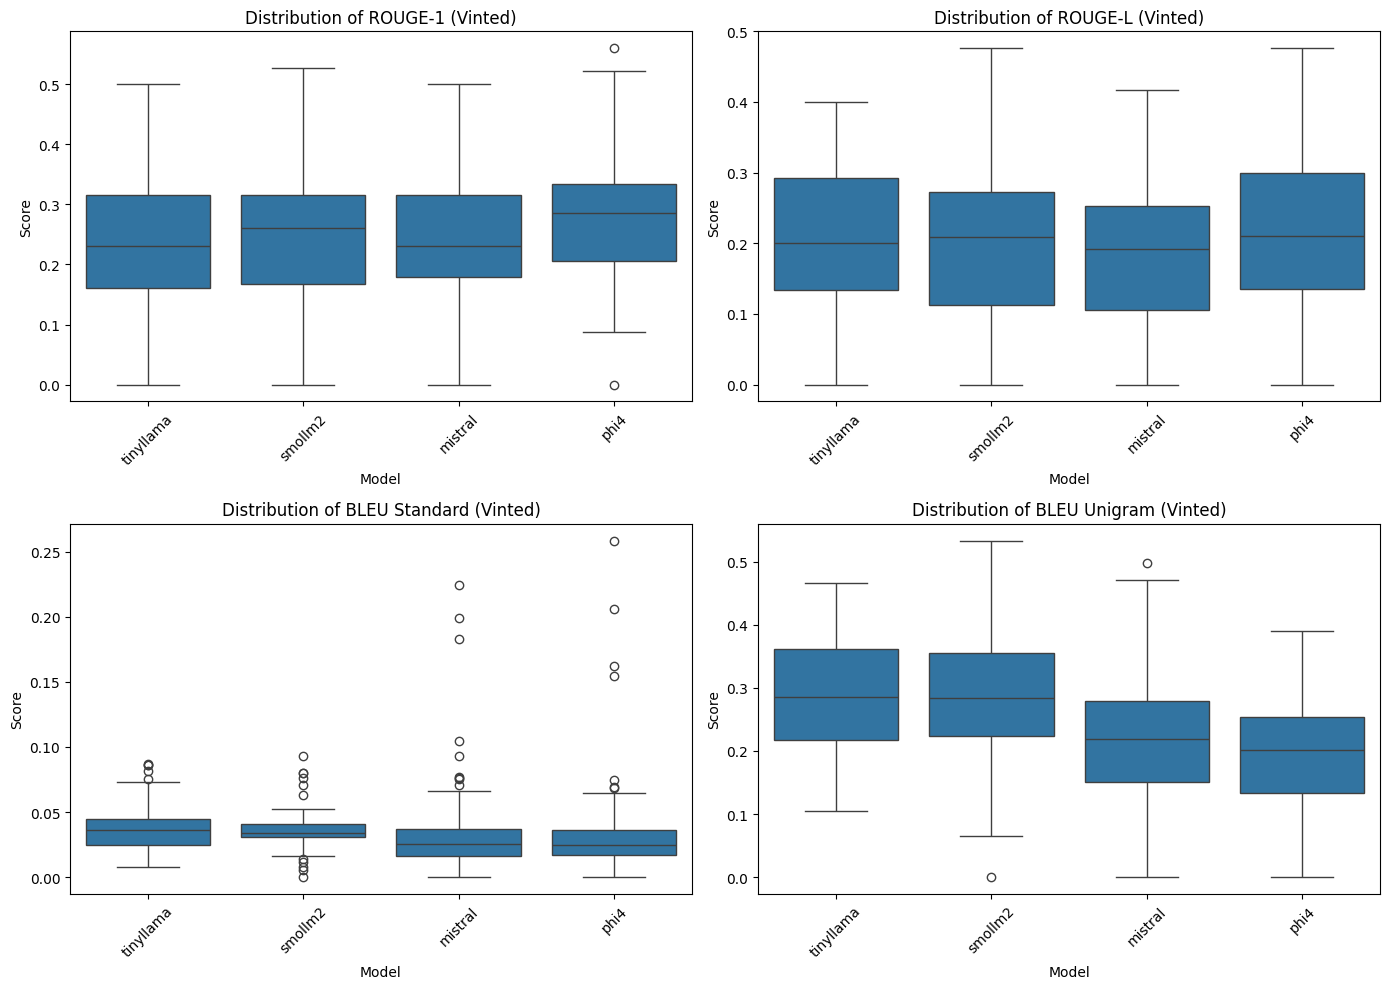

In [ ]:
# Box plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
metric_labels = ['ROUGE-1', 'ROUGE-L', 'BLEU Standard', 'BLEU Unigram']

for i, metric in enumerate(metrics):
    # Combine data for each metric across models
    data = pd.concat([all_results[model]['results_df'][[metric]].assign(Model=model)
                      for model in all_results], axis=0)
    sns.boxplot(x='Model', y=metric, data=data, ax=axes[i])
    axes[i].set_title(f'Distribution of {metric_labels[i]} (Vinted)', fontsize=12)
    axes[i].set_xlabel('Model', fontsize=10)
    axes[i].set_ylabel('Score', fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("Vinted Box Plots LLM Results.png")
plt.show()

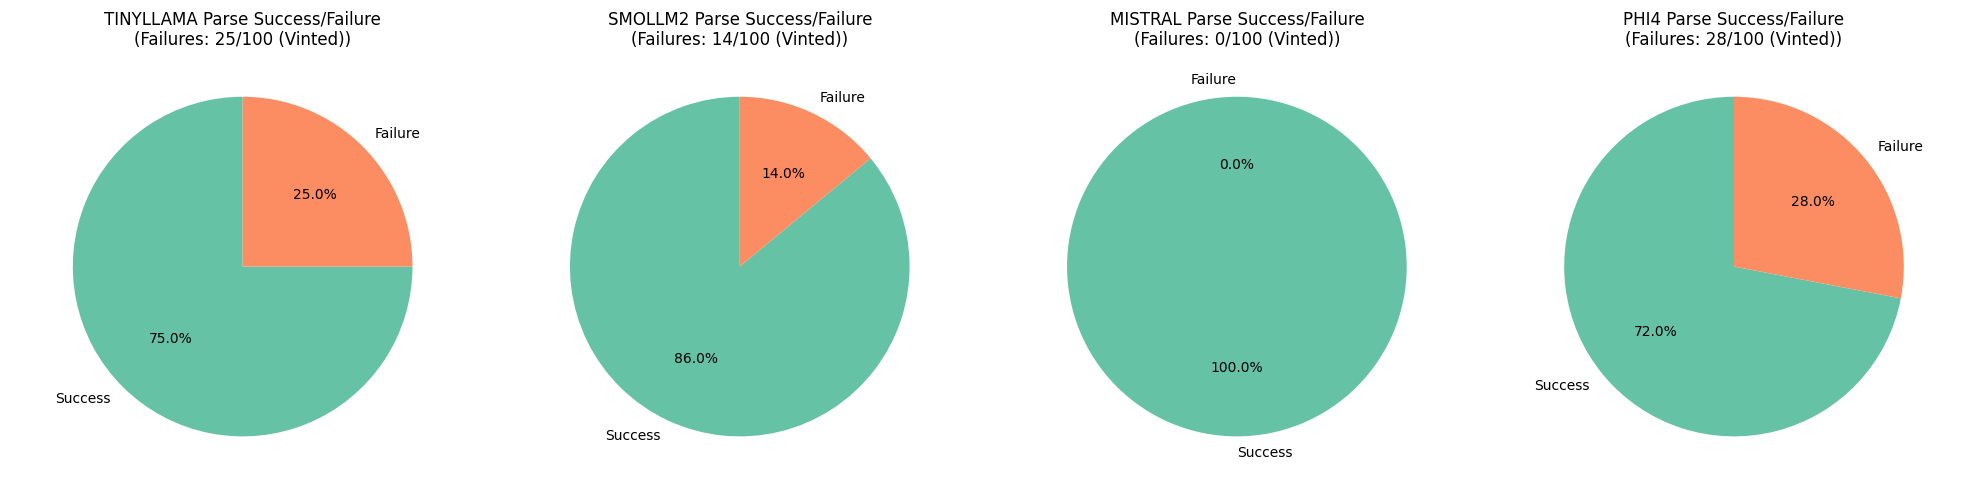

In [ ]:
# Pie charts for each model
fig, axes = plt.subplots(1, len(all_results), figsize=(5 * len(all_results), 5))
if len(all_results) == 1:
    axes = [axes]  # Handle single model case

for i, model in enumerate(all_results):
    failed = all_results[model]['failed_count']
    success = num_samples - failed
    labels = ['Success', 'Failure']
    sizes = [success, failed]
    colors = ['#66c2a5', '#fc8d62']  # Green and orange for success and failure
    axes[i].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'{model.upper()} Parse Success/Failure\n(Failures: {failed}/{num_samples} (Vinted))', fontsize=12)
    axes[i].axis('equal')  # Equal aspect ratio for circular pie

plt.tight_layout()
plt.savefig("Vinted Parsing Success Rates.png")
plt.show()